In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Proof 1

In [2]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 8.1 MB/s eta 0:00:00


In [3]:
f = open('/content/drive/MyDrive/data/processed_stars/books/all_balanced.review', 'r')
text = f.read()
f.close()
text = text[:-1]

In [4]:
text.split('\n')[0]

'helpful:1 voices_of:1 the_levels:1 it:1 only_knew:1 "if_i:1 guidance_in:1 departing_one:1 familiarize:1 meaning:1 self_is:1 can_be:1 knowledge:3 koan\'s_since:1 be:1 experiences_actions:1 spiritually_the:1 you_to:1 collection:1 with_not:1 as:1 disciplines_spiritually:1 levels:1 that_i:1 work_but:1 to_anything:1 each_statement:1 much_much:1 dhu-l-nun:1 a_quote:1 badruddin:1 all_through:1 sets:1 but:1 chapters_offer:1 actions_remembrances:1 one_from:1 revisited_for:1 sufisim:1 some:1 fallow:1 upon:1 which:1 bistami_and:1 more_a:1 not_only:1 bayazid:1 path_of:1 awakening:1 the_many:1 intellective_sufis:1 experiences:1 and_all:1 great:3 and_much:1 yourself:1 through_the:1 guidance\'s._the:1 in_a:1 upon_awakening:1 meaning_for:1 introducing_hadiths:1 fantasic:1 guidance\'s.:1 had_taken:1 point_it:1 contemplation_in:1 value:1 quote_from:1 sincerity:1 remembrances_and:1 of_guidance:1 compared:1 find_no:1 eternal_intellective:1 to_the:1 touch:1 be_compared:1 actions:1 compared_some:1 is_true:

In [5]:
reviews = []
for line in text.split('\n'):
    review = line.split('#label#:')
    reviews.append(review[0])
reviews = '\n'.join(reviews)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

reviewsT = reviews.split('\n')
# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
# Transform book reviews into a TF-IDF vector
X = vectorizer.fit_transform(reviewsT)

In [7]:
from sklearn.feature_selection import SelectKBest, chi2

data_chi2 = text.split('\n')
# Extract review ratings
y = [float(d.split('#label#:')[-1].split(':')[0]) if d.split('#label#:')[-1].split(':')[0] else None for d in data_chi2]

# Create a feature selector
selector = SelectKBest(chi2, k=100)
# Select the most important features
X_t = selector.fit_transform(X, y)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

train_vectors, test_vectors, train_labels, test_labels = train_test_split(X_t, y, test_size=0.1, random_state=42)

In [10]:
clf1 = LogisticRegression().fit(train_vectors, train_labels)
print('Score for Random Forest Classifier = {}'.format(clf1.score(test_vectors, test_labels)))

clf2 = RandomForestClassifier().fit(train_vectors, train_labels)
print('Score for Random Forest Classifier = {}'.format(clf2.score(test_vectors, test_labels)))

clf3 = BernoulliNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Bernoulli = {}'.format(clf3.score(test_vectors, test_labels)))

clf4 = ComplementNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Complement = {}'.format(clf4.score(test_vectors, test_labels)))

clf5 = MultinomialNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Multinomial = {}'.format(clf5.score(test_vectors, test_labels)))

Score for Random Forest Classifier = 0.4519056261343013
Score for Random Forest Classifier = 0.41742286751361163
Score for Naive Bayes Bernoulli = 0.4809437386569873
Score for Naive Bayes Complement = 0.46823956442831216
Score for Naive Bayes Multinomial = 0.4591651542649728


For now the best score was with the classification model Naive Bayes Bernoulli (48%)

<Axes: >

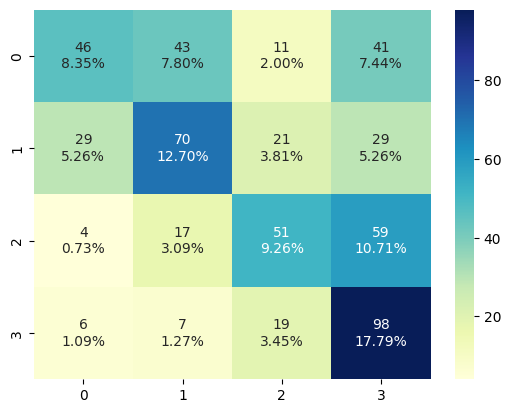

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(test_labels, clf3.predict(test_vectors))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

annot = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(4,4)
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu')

## Proof 2

In [25]:
import nltk
bag_of_words = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    for key_value in seq[0].split(' '):
      bag_of_words.append(key_value.split(':')[0])
fdist = nltk.FreqDist(bag_of_words)

In [27]:
len(fdist)

401727

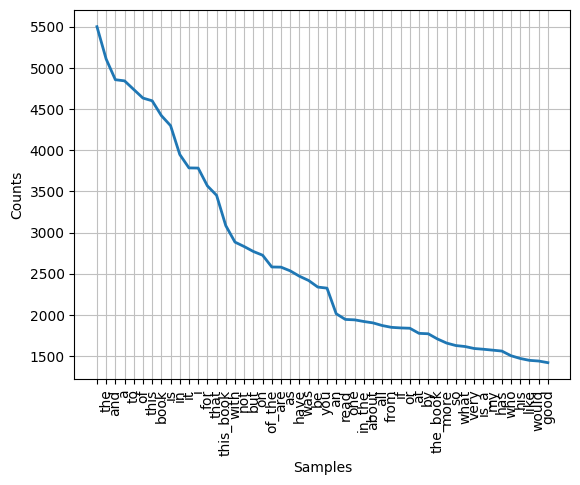

<Axes: xlabel='Samples', ylabel='Counts'>

In [26]:
fdist.plot(50)

In [28]:
reduced_bow = [w for w in set(bag_of_words) if fdist[w]>100]
len(reduced_bow)

1214

In [29]:
import numpy as np

vectors = []
labels = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    line_dict = {keyval.split(':')[0]: int(keyval.split(':')[1]) for keyval in seq[0].split(' ') if len(keyval.split(':'))==2}
    line_vector = []
    for word in reduced_bow:
      if word in line_dict.keys():
        line_vector.append(line_dict[word])
      else:
        line_vector.append(0)
    vectors.append(line_vector)
    labels.append(float(seq[1]))

vectors = np.array(vectors)

In [30]:
vectors

array([[ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  0,  0,  3],
       [ 0,  0,  0, ...,  0,  0,  3],
       ...,
       [ 0,  1,  0, ...,  0,  0,  5],
       [ 0,  0,  0, ...,  0,  0, 10],
       [ 0,  0,  0, ...,  0,  0,  3]])

In [31]:
set(labels)

{1.0, 2.0, 4.0, 5.0}

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=42)

In [33]:
clf = MultinomialNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Multinomial = {}'.format(clf.score(test_vectors, test_labels)))

clf2 = RandomForestClassifier().fit(train_vectors, train_labels)
print('Score for RandomForestClassifier = {}'.format(clf2.score(test_vectors, test_labels)))

clf3 = BernoulliNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Bernoulli = {}'.format(clf3.score(test_vectors, test_labels)))

clf4 = ComplementNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Complement = {}'.format(clf4.score(test_vectors, test_labels)))

Score for Naive Bayes Multinomial = 0.5081669691470054
Score for RandomForestClassifier = 0.5208711433756806
Score for Naive Bayes Bernoulli = 0.43920145190562615
Score for Naive Bayes Complement = 0.49909255898366606


For now the best score was with the classification model Random Forest Classifier (52%)

<Axes: >

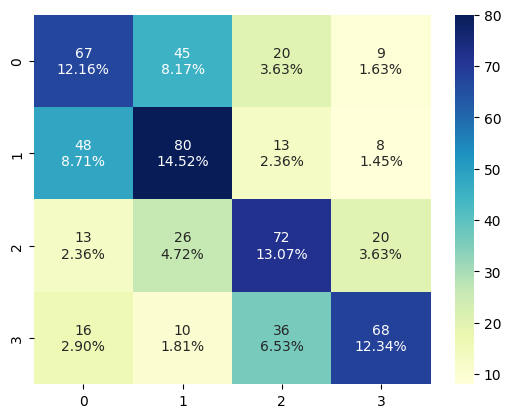

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, clf2.predict(test_vectors))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

annot = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(4,4)
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu')

## Final Proof

In [48]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

bag_of_words = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    for key_value in seq[0].split(' '):
      bag_of_words.append(key_value.split(':')[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
stopwords = stopwords.words('english')
bag_of_words = [w for w in bag_of_words if w.lower() not in stopwords]
fdist = nltk.FreqDist(bag_of_words)

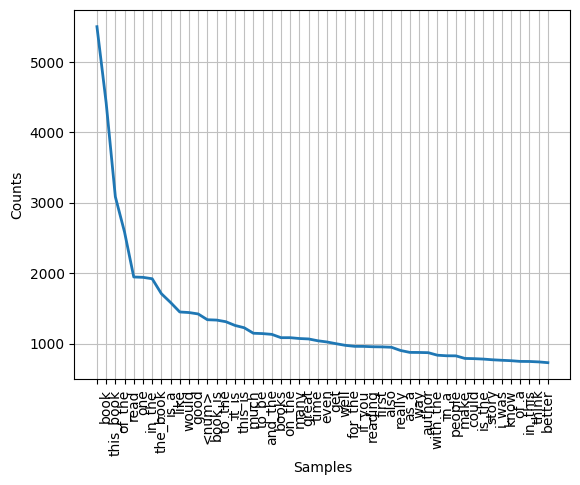

<Axes: xlabel='Samples', ylabel='Counts'>

In [50]:
fdist.plot(50)

In [51]:
# We separate frequencies that have more than 50 repetitions
reduced_bow = [w for w in set(bag_of_words) if fdist[w]>50]
# We take out the biograms
bigram_text = nltk.Text(bag_of_words)
bigrams = list(nltk.bigrams(bigram_text))
# We separate the most common bigrams
top_bigrams = (nltk.FreqDist(bigrams)).most_common(250)

In [52]:
import numpy as np

vectors = []
labels = []
for line in text.split('\n'):
  seq = line.split('#label#:')
  if len(seq)==2:
    line_dict = {keyval.split(':')[0]: int(keyval.split(':')[1]) for keyval in seq[0].split(' ') if len(keyval.split(':'))==2}
    line_vector = []
    for word in reduced_bow:
      if word in line_dict.keys():
        line_vector.append(line_dict[word])
      else:
        line_vector.append(0)
    vectors.append(line_vector)
    labels.append(float(seq[1]))

    bigram_text = nltk.Text(line_dict.keys())
    bigrams = list(nltk.bigrams(bigram_text))
    for word in top_bigrams:
      if word in bigrams:
        line_vector.append(1)
      else:
        line_vector.append(0)
    vectors.append(line_vector)
    labels.append(float(seq[1]))

vectors = np.array(vectors)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=42)

In [57]:
clf1 = RandomForestClassifier().fit(train_vectors, train_labels)
print('Score for RandomForestClassifier = {}'.format(clf1.score(test_vectors, test_labels)))

clf2 = BernoulliNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Bernoulli = {}'.format(clf2.score(test_vectors, test_labels)))

clf3 = ComplementNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Complement = {}'.format(clf3.score(test_vectors, test_labels)))

clf4 = MultinomialNB().fit(train_vectors, train_labels)
print('Score for Naive Bayes Multinomial = {}'.format(clf4.score(test_vectors, test_labels)))

Score for RandomForestClassifier = 0.9545867393278837
Score for Naive Bayes Bernoulli = 0.553133514986376
Score for Naive Bayes Complement = 0.6512261580381471
Score for Naive Bayes Multinomial = 0.6530426884650318


The best score was with the classification model Random Forest Classifier (95%)

<Axes: >

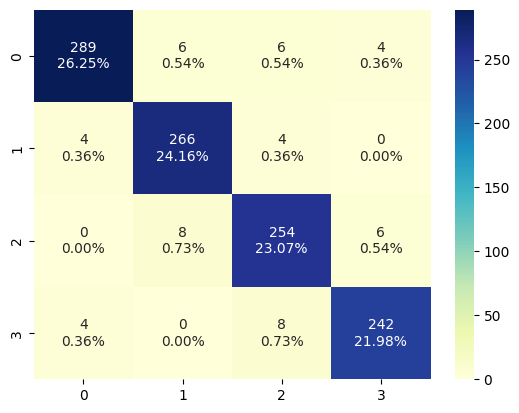

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, clf1.predict(test_vectors))

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

annot = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
annot = np.asarray(annot).reshape(4,4)
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu')